# Representation learning with Autoencoders

In this project, we will solve a 2-class classification problem using Epilespy EEG data.



The dataset is available from https://zenodo.org/record/3684992

This dataset was generated with a motive to build predictive epilepsy diagnosis models. It was generated on a similar acquisition and settings i.e., sampling frequency, bandpass filtering and number of signals and time duration as
its much more famous counterpart - the University of Bonn dataset. It has overcome the limitations faced by the University of Bonn dataset, such as different EEG recording sites (inter-cranial and scalp) for healthy and epileptic patients. All the data were taken exclusively using surface EEG electrodes.

Dataset for Training/Testing of Existing Models and Algorithms:

"This dataset was collected exclusively from scalp EEG taken from the same EEG machine and contains data of 30 subjects- 15 healthy and 15 epileptic subjects. Like the previous studies, the data of 5 healthy and 5 epileptic subjects was used for training and validation. The rest, i.e., the data of 10 healthy and 10 epilepsy subjects, was used for testing such that there was no overlap of subjects between the training/validation dataset and the testing dataset. In the training/validation dataset, forty EEG segments, of 23.6 seconds duration each, were utilized. In the testing dataset, twenty EEG segments of 23.6 seconds duration each per subject were utilized. Similar to the benchmark dataset, each class in the training/validation and test sets had 200 artefact free EEG segments. Along with the duration, all the EEG segments in these datasets also met the bandwidth (0.5-40 Hz), sampling rate (173.6 Hz) and stationarity criteria of the benchmark dataset. This dataset is used as an alternate dataset to the benchmark dataset because benchmark dataset is data collected differently for the two classes (from scalp and from cortex). Thus, this dataset allows us to evaluate the performance of existing features and algorithms when trained and tested on a dataset collected consistently for the two classes, i.e., from the scalp."

S. Panwar, S. D. Joshi, A. Gupta and P. Agarwal, "Automated Epilepsy Diagnosis Using EEG With Test Set Evaluation," in IEEE Transactions on Neural Systems and Rehabilitation Engineering, vol. 27, no. 6, pp. 1106-1116, June 2019, doi: 10.1109/TNSRE.2019.2914603.
https://ieeexplore.ieee.org/abstract/document/8705361

In [1]:
# load libraries
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
import glob
import keras
!pip install wget
import wget
from keras.layers import Input, Conv1D, Dense, MaxPooling1D, Dropout, UpSampling1D,ZeroPadding1D,BatchNormalization,Flatten,Reshape
from keras.models import Model
from keras.models import Sequential
from keras.utils.np_utils import to_categorical

import pandas as pd
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a6755ffcafc32e634e3e6aa3873da53a931c999e9f5f30ccb6fe8ac48b7bb6bc
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


Create a new folder in your Google Drive to store the data, make that your current working directory and run the following code block to download all the dataset files. 

In [2]:
drive.mount('/content/drive/') # Mounting Drive
os.chdir('/content/drive/My Drive/LAB 8/Data') # Changing Directory

Mounted at /content/drive/


In [ ]:
# Downloading the dataset
for cat in ['E', 'H']: 
  for pid in range(1,6):
    for filenum in range(1,41):
      dataFile = 'Train' + cat + str(pid) + '_' + str(filenum) + '.txt'
      if os.path.exists(dataFile):
        continue
      else:
        url = 'https://zenodo.org/record/3684992/files/' + dataFile + '?download=1'
        file_name = wget.download(url)
        print(file_name)

for cat in ['E', 'H']: 
  for pid in range(1,11):
    for filenum in range(1,21):
      dataFile = cat + str(pid) + '_' + str(filenum) + '.txt'
      if os.path.exists(dataFile):
        continue
      else:
        url = 'https://zenodo.org/record/3684992/files/' + dataFile + '?download=1'
        file_name = wget.download(url)
        print(file_name)

**TASK 1: (Data Preparation)** 

Please read the description of the dataset carefully (provided in the download link).

For this project, we will not use the standard dataset partition suggested in the paper describing the corpus. We will employ all the files starting with 'Train' along with the files starting with E1 to E8 and H1 to H8 as our training data (that is a total of 26 participants.) 

Files of subjects E9, E10, H9 and H10 (4 participants) will be our validation data. 

Load all the EEG files into two data matrices for train and test. The matrices should have dimensions N x S. Where is N is number of data points (~2800 for train and ~300 for test). 
A single data point corresponds to a contiguous S=868 sample length (about 5s given the sampling rate of 173.6 Hz) from an EEG file. These 5 second segments are non-overlapping portions from the datasets.

The labels should be 0 or 1 (epilepsy or healthy). If you choose to store labels in other format like "one-hot encoding", y.shape would be Nx2.

Next, normalize all data to range of [-1,1] 

Note: If you are having issues downloading the dataset from the link provided above, you can download it from this Google Drive folder

https://drive.google.com/drive/folders/11YArqE0h5Z3fxCvR5aDH8W37z-d5t9aE?usp=sharing

In [3]:
filepath_TE = glob.glob('/content/drive/My Drive/LAB 8/Data/TrainE*') # Path for files with Train E in their name
filepath_TH = glob.glob('/content/drive/My Drive/LAB 8/Data/TrainH*') # Path for files with Train H in their name
filepath_EH = glob.glob('/content/drive/My Drive/LAB 8/Data/[EH][1-8]*') # Path for files with E and H and numbers 1-8 in their name
filepath_E = glob.glob('/content/drive/My Drive/LAB 8/Data/E10*') # Path for files with E10 in their name
filepath_H = glob.glob('/content/drive/My Drive/LAB 8/Data/H10*') # Path for files with H10 in their name
filepath_E1_8 = glob.glob('/content/drive/My Drive/LAB 8/Data/E[1-8]*') # Path for files with E and numbers 1-8 in their name
filepath_H1_8 = glob.glob('/content/drive/My Drive/LAB 8/Data/H[1-8]*') # Path for files with H and numbers 1-8 in their name


# Preparing Train Data

train_matrix = np.array([]).reshape(0,868) # Initializing train matrix


#Code to remove filepaths of E10 and H10
a = []
for b in filepath_EH:
  if  b in filepath_E:
    continue
  elif  b in filepath_H:
    continue
  else:
    a.append(b)


filepath_train = a + filepath_TE+filepath_TH # Final train data paths

In [4]:
# Code for forming train matrix
filepath_train = a + filepath_TE+filepath_TH # Final train data paths
for i in range(len(filepath_train)):
  tr= np.loadtxt(filepath_train[i])
  train_matrix = np.vstack([train_matrix, tr[0:868]])
  train_matrix = np.vstack([train_matrix, tr[868:868*2]])
  train_matrix = np.vstack([train_matrix, tr[868*2:868*3]])
  train_matrix = np.vstack([train_matrix, tr[868*3:868*4]])


In [5]:
# Labels for train data
label_TH = np.ones(4*len(filepath_TH))
label_TE = np.zeros(4*len(filepath_TE))
label_TstE = np.zeros(4*(len(filepath_E1_8)-len(filepath_E)))
label_TstH = np.ones(4*(len(filepath_H1_8)-len(filepath_H)))
label = np.concatenate((label_TstE,label_TstH,label_TE,label_TH,),axis=0)



In [6]:
# Normalizing train matrix to range [-1 1]
abs = np.absolute(train_matrix)
abs = np.max(abs, axis=0)
train_matrix = train_matrix/abs

In [7]:
# Preparing Testing Data
filepath_E9 = glob.glob('/content/drive/My Drive/LAB 8/Data/E9*') # Path for files with E9 in their name
filepath_H9 = glob.glob('/content/drive/My Drive/LAB 8/Data/H9*') # Path for files with H9 in their name
filepath_test = filepath_E9+filepath_E+filepath_H9+filepath_H; # Final tesst files paths
test_matrix = np.array([]).reshape(0,868) # Initialize test matrix

# Code for forming test matrix
for i in range(len(filepath_test)):
  tr= np.loadtxt(filepath_test[i])
  test_matrix = np.vstack([test_matrix, tr[0:868]])
  test_matrix = np.vstack([test_matrix, tr[868:868*2]])
  test_matrix = np.vstack([test_matrix, tr[868*2:868*3]])
  test_matrix = np.vstack([test_matrix, tr[868*3:868*4]])

In [8]:
#Labels for Test
label_H = np.ones(4*(len(filepath_H9)+len(filepath_H)))
label_E = np.zeros(4*(len(filepath_E9)+len(filepath_E)))
label_test = np.concatenate((label_E,label_H),axis=0)

# Normalizing test matrix to range [-1 1]
abst = np.absolute(test_matrix)
abst = np.max(abst,axis=0)
test_matrix = test_matrix/abst


**TASK 2: (Auto-encoder training)** 
We will create an autoencoder based on the analysis methodology described in this paper. 
https://www.sciencedirect.com/science/article/pii/S0957417420306114

Using Keras, create and train the auto-encoder specified in the paper.
An autoencoder is a specific type of a neural network, which is mainly designed to encode the input into a compressed and meaningful representation, and then decode it back such that the reconstructed input is similar as possible to the original one.
We will refer to this model as *original auto-encoder* in this lab.
We provide the Table 9 from the paper which specifies all details of the network below. Choose MSE (mean squared error) as loss function.
Your loss must decrease with epochs.

Hint 1: It would be useful to use `print(autoencoder.summary())` to verify if your architecture is correct.

Hint 2: Convolutional layers need to be modified such that they do not modify the length of input signal. Also, ensure the output of network is same shape as input.

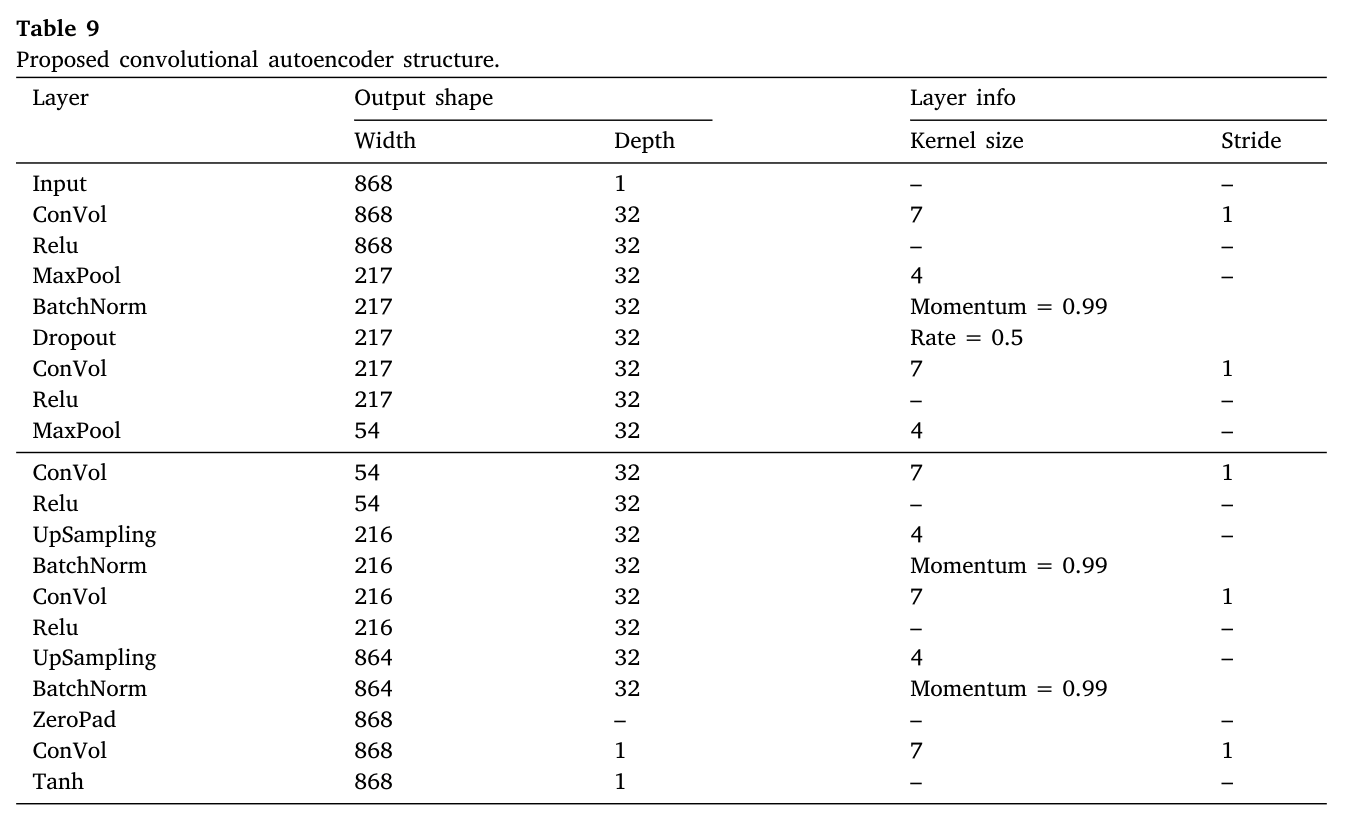

In [9]:
from keras import layers
# Encoder Model
input = Input(shape=(868,1))
original_encoder = Sequential()
original_encoder.add(Conv1D(filters= 32,kernel_size=7,activation = 'relu',input_shape=(868,1),padding = 'same'))
original_encoder.add(MaxPooling1D(pool_size=4,strides=None))
original_encoder.add(BatchNormalization( momentum=0.99))
original_encoder.add(Dropout(rate=0.5))
original_encoder.add(Conv1D(filters= 32,kernel_size=7,activation = 'relu',padding='same'))
original_encoder.add(MaxPooling1D(pool_size=4,strides=None))

original_encoder.summary()

# Decoder Model
decoder = Sequential()
decoder.add(Conv1D(filters= 32,kernel_size=7,activation = 'relu',input_shape=(54,32),padding = 'same'))
decoder.add(UpSampling1D(size = 4))
decoder.add(BatchNormalization( momentum=0.99))
decoder.add(Conv1D(filters= 32,kernel_size=7,activation = 'relu',padding='same'))
decoder.add(UpSampling1D(size = 4))
decoder.add(BatchNormalization( momentum=0.99))
decoder.add(ZeroPadding1D(padding=2))
decoder.add(Conv1D(filters= 1,kernel_size=7,activation = 'tanh',padding = 'same'))

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 868, 32)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 217, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 217, 32)          128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 217, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 217, 32)           7200      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 32)           0

In [10]:
# Autoencoder model
autoencoder = Model(input,decoder(original_encoder(input)))
autoencoder.compile(loss='mse',optimizer='adam',metrics=['mse'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 868, 1)]          0         
                                                                 
 sequential (Sequential)     (None, 54, 32)            7584      
                                                                 
 sequential_1 (Sequential)   (None, 868, 1)            14881     
                                                                 
Total params: 22,465
Trainable params: 22,273
Non-trainable params: 192
_________________________________________________________________


In [ ]:
# Fitting the autoencoder
history = autoencoder.fit(train_matrix,train_matrix,epochs=50,shuffle=True,batch_size=32)

Epoch 1/50
90/90 [==============================] - 15s 115ms/step - loss: 0.0462 - mse: 0.0462
Epoch 2/50
90/90 [==============================] - 10s 110ms/step - loss: 0.0118 - mse: 0.0118
Epoch 3/50
90/90 [==============================] - 10s 110ms/step - loss: 0.0101 - mse: 0.0101
Epoch 4/50
90/90 [==============================] - 10s 112ms/step - loss: 0.0094 - mse: 0.0094
Epoch 5/50
90/90 [==============================] - 10s 115ms/step - loss: 0.0085 - mse: 0.0085
Epoch 6/50
90/90 [==============================] - 10s 111ms/step - loss: 0.0078 - mse: 0.0078
Epoch 7/50
90/90 [==============================] - 10s 114ms/step - loss: 0.0074 - mse: 0.0074
Epoch 8/50
90/90 [==============================] - 10s 110ms/step - loss: 0.0068 - mse: 0.0068
Epoch 9/50
90/90 [==============================] - 10s 109ms/step - loss: 0.0065 - mse: 0.0065
Epoch 10/50
90/90 [==============================] - 10s 109ms/step - loss: 0.0062 - mse: 0.0062
Epoch 11/50
90/90 [====================

**TASK 3: (Visualization of reconstruction)** Let x be a 868-sample long data point from your test set, e() be encoder, d() be decoder. The reconstuction/auto-encoding of x is given by d(e(x)) i.e. simply forward pass of x through the auto-encoder. On separate figures, (1) plot one signal from test set and its reconstructed version.

Also, answer the following questions:
(2) What is the dimension of encoding $z$ (learned representation) of x? If you find the encoding $z$ to be multi-dimensional i.e. `len(z.shape) > 1`, then the encoding dimension is defined as `np.prod(z.shape)`
 (3) Comment on the relation between the obtained dimension of learned representation and reconstructed signal quality.

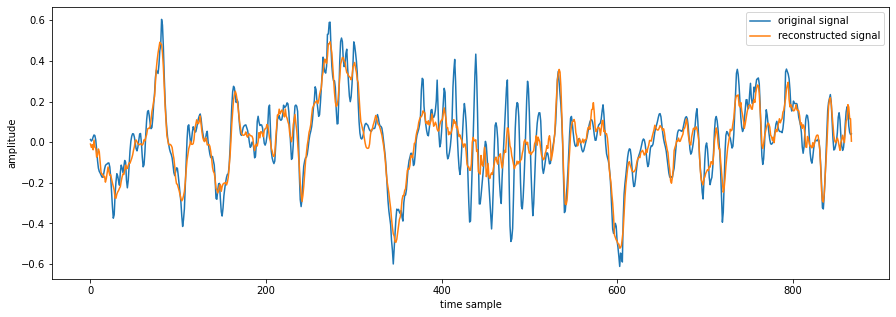

In [ ]:
# Visualizing Reconstruction
encode = original_encoder.predict(test_matrix)
decode = decoder.predict(encode)
plt.figure(figsize=(15, 5))
plt.plot(test_matrix[2,:]) #original signal
plt.plot(np.squeeze(decode[2,:])) # reconstructed signal
plt.ylabel('amplitude')
plt.xlabel('time sample')
plt.legend(['original signal', 'reconstructed signal'])
plt.show()

In [ ]:
# dimesion of encoding 
z = np.prod(encode.shape) 

decode_dim = np.prod(decode.shape)
print('Encoded Dimension ',z)
print('Recontructed Dimension',decode_dim)

Encoded Dimension  552960
Recontructed Dimension 277760


**As we can see that the reconsturcted dimesion is less than encoded dimesion, the quality of the signal is hampered**

**TASK 4 (Training classifier)**: Discarding the decoder, append a simple classifier at the end of your trained encoder. The classifier (excluding your encoder) is a M=100 unit dense layer followed by your favorite activation function followed by 2-class softmax classification. Encoder must be frozen in this training. Report accuracy on test set.

In [ ]:
# training classifier 
for layer in original_encoder.layers:
 layer.trainable = False         #Encoder layer frozen

encoder_classifier = Sequential()
encoder_classifier.add(original_encoder) # adding encoder
encoder_classifier.add(Flatten())   
encoder_classifier.add(Dense(100, activation='relu'))  
encoder_classifier.add(Dense(2, activation='softmax')) 
encoder_classifier .summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 54, 32)            7584      
                                                                 
 flatten (Flatten)           (None, 1728)              0         
                                                                 
 dense (Dense)               (None, 100)               172900    
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 180,686
Trainable params: 173,102
Non-trainable params: 7,584
_________________________________________________________________


In [ ]:
Labels = to_categorical(label, num_classes=2) #Converting labels to categorical

encoder_classifier.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
encoder_classifier_history=encoder_classifier.fit(train_matrix,Labels, epochs=60,batch_size = 32,verbose=1,shuffle=True)

Epoch 1/60
90/90 [==============================] - 2s 18ms/step - loss: 0.7138 - accuracy: 0.7181
Epoch 2/60
90/90 [==============================] - 2s 18ms/step - loss: 0.4461 - accuracy: 0.7924
Epoch 3/60
90/90 [==============================] - 2s 18ms/step - loss: 0.4130 - accuracy: 0.8174
Epoch 4/60
90/90 [==============================] - 2s 19ms/step - loss: 0.3636 - accuracy: 0.8351
Epoch 5/60
90/90 [==============================] - 2s 18ms/step - loss: 0.3621 - accuracy: 0.8368
Epoch 6/60
90/90 [==============================] - 2s 18ms/step - loss: 0.3353 - accuracy: 0.8503
Epoch 7/60
90/90 [==============================] - 2s 18ms/step - loss: 0.3366 - accuracy: 0.8569
Epoch 8/60
90/90 [==============================] - 2s 18ms/step - loss: 0.3049 - accuracy: 0.8670
Epoch 9/60
90/90 [==============================] - 2s 18ms/step - loss: 0.2701 - accuracy: 0.8830
Epoch 10/60
90/90 [==============================] - 2s 17ms/step - loss: 0.2419 - accuracy: 0.8944
Epoch 11/

In [ ]:
Labels_test = to_categorical(label_test,num_classes=2) # Test labels to categorical
test_accu = encoder_classifier.evaluate(test_matrix,Labels_test) # Reporting Test accuracy

10/10 [==============================] - 0s 15ms/step - loss: 4.1282 - accuracy: 0.6000


**TASK 5 (Modifying bottleneck of auto-encoder)**: Let us treat K (encoded dimension) a as hyper-parameter. Your goal is to ensure K is approximately half of signal length i.e. 868/2 = 434. It is OK if your reduced dimension is in +/-10% range of 434. You will accomplish this by modifying/adding/removing ONLY the following three types of layers: Upsampling, ZeroPadding, and MaxPooling layer. Like previous tasks, first train the autoencoder, then train the subsequent classifier (keeping encoder frozen), and finally report test accuracy. The classifier architecture remains same as before. Also, display a test image and its reconstruction using this auto-encoder. What is your comment on it?

In [11]:
# Modified Bottle Neck autoencoder
# Model for encoder
input = Input(shape=(868,1))
mod_encoder = Sequential()
mod_encoder.add(Conv1D(filters= 32,kernel_size=7,activation = 'relu',input_shape=(868,1),padding = 'same'))
mod_encoder.add(MaxPooling1D(pool_size=2,strides=None))
mod_encoder.add(BatchNormalization( momentum=0.99))
mod_encoder.add(Dropout(rate=0.5))
mod_encoder.add(Conv1D(filters= 32,kernel_size=7,activation = 'relu',padding='same'))

original_encoder.summary()

# Model for decoder
mod_decoder = Sequential()
mod_decoder.add(Conv1D(filters= 32,kernel_size=7,activation = 'relu',input_shape=(434,32),padding = 'same'))
mod_decoder.add(UpSampling1D(size = 1))
mod_decoder.add(BatchNormalization( momentum=0.99))
mod_decoder.add(Conv1D(filters= 32,kernel_size=7,activation = 'relu',padding='same'))
mod_decoder.add(UpSampling1D(size = 2))
mod_decoder.add(BatchNormalization( momentum=0.99))
mod_decoder.add(Conv1D(filters= 1,kernel_size=7,activation = 'tanh',padding = 'same'))

mod_decoder.summary()

#Model for autoencoder
mod_autoencoder = Model(input,mod_decoder(mod_encoder(input)))
mod_autoencoder.compile(loss='mse',optimizer='adam',metrics=['mse'])
mod_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 868, 32)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 217, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 217, 32)          128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 217, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 217, 32)           7200      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 32)           0

In [ ]:
#Fitting the model
history = mod_autoencoder.fit(train_matrix,train_matrix,epochs=50,shuffle=True,batch_size=32)

Epoch 1/50
90/90 [==============================] - 20s 170ms/step - loss: 0.0396 - mse: 0.0396
Epoch 2/50
90/90 [==============================] - 15s 169ms/step - loss: 0.0044 - mse: 0.0044
Epoch 3/50
90/90 [==============================] - 15s 169ms/step - loss: 0.0028 - mse: 0.0028
Epoch 4/50
90/90 [==============================] - 15s 167ms/step - loss: 0.0025 - mse: 0.0025
Epoch 5/50
90/90 [==============================] - 15s 170ms/step - loss: 0.0019 - mse: 0.0019
Epoch 6/50
90/90 [==============================] - 15s 170ms/step - loss: 0.0017 - mse: 0.0017
Epoch 7/50
90/90 [==============================] - 15s 171ms/step - loss: 0.0019 - mse: 0.0019
Epoch 8/50
90/90 [==============================] - 15s 170ms/step - loss: 0.0015 - mse: 0.0015
Epoch 9/50
90/90 [==============================] - 15s 172ms/step - loss: 0.0016 - mse: 0.0016
Epoch 10/50
90/90 [==============================] - 15s 168ms/step - loss: 0.0014 - mse: 0.0014
Epoch 11/50
90/90 [====================

In [ ]:
# Modified encoder classsifier
for layer in mod_encoder.layers: #freezing encoder layers
 layer.trainable = False        

encoder_classifier_mod = Sequential()
encoder_classifier_mod.add(mod_encoder)
encoder_classifier_mod.add(Flatten())   
encoder_classifier_mod.add(Dense(100, activation='relu'))  
encoder_classifier_mod.add(Dense(2, activation='softmax')) 
encoder_classifier_mod.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_29 (Sequential)  (None, 434, 32)           7584      
                                                                 
 flatten_11 (Flatten)        (None, 13888)             0         
                                                                 
 dense_20 (Dense)            (None, 100)               1388900   
                                                                 
 dense_21 (Dense)            (None, 2)                 202       
                                                                 
Total params: 1,396,686
Trainable params: 1,389,102
Non-trainable params: 7,584
_________________________________________________________________


In [ ]:
#Fitting the model
encoder_classifier_mod.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
encoder_classifier_mod_history=encoder_classifier_mod.fit(train_matrix,Labels, epochs=60,batch_size = 32,verbose=1,shuffle=True)

Epoch 1/60
90/90 [==============================] - 3s 28ms/step - loss: 0.9124 - accuracy: 0.6267
Epoch 2/60
90/90 [==============================] - 2s 27ms/step - loss: 0.6042 - accuracy: 0.7319
Epoch 3/60
90/90 [==============================] - 2s 27ms/step - loss: 0.5144 - accuracy: 0.7424
Epoch 4/60
90/90 [==============================] - 2s 27ms/step - loss: 0.4656 - accuracy: 0.7740
Epoch 5/60
90/90 [==============================] - 2s 27ms/step - loss: 0.4404 - accuracy: 0.7927
Epoch 6/60
90/90 [==============================] - 2s 27ms/step - loss: 0.4161 - accuracy: 0.8076
Epoch 7/60
90/90 [==============================] - 2s 28ms/step - loss: 0.4004 - accuracy: 0.8198
Epoch 8/60
90/90 [==============================] - 2s 27ms/step - loss: 0.3967 - accuracy: 0.8163
Epoch 9/60
90/90 [==============================] - 2s 27ms/step - loss: 0.3798 - accuracy: 0.8201
Epoch 10/60
90/90 [==============================] - 2s 27ms/step - loss: 0.3606 - accuracy: 0.8431
Epoch 11/

In [ ]:
test_accu = encoder_classifier_mod.evaluate(test_matrix,Labels_test) #test accuracy

10/10 [==============================] - 0s 15ms/step - loss: 5.9920 - accuracy: 0.5125


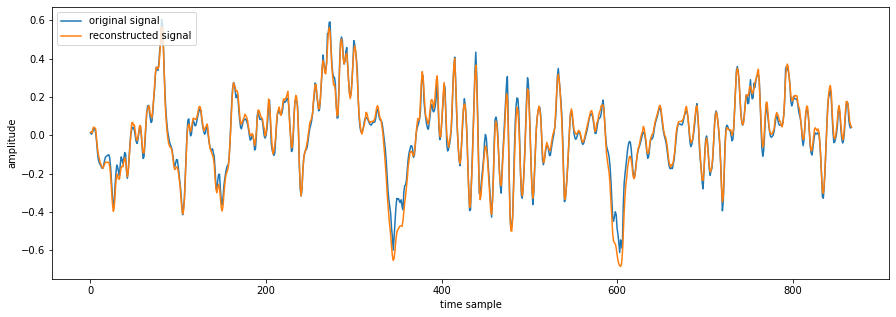

In [ ]:
# visualization
mod_decode = mod_autoencoder.predict(test_matrix)

plt.figure(figsize=(15, 5)) # Original Signal
plt.plot(test_matrix[2,:] # reconstructed signal
plt.plot(np.squeeze(mod_decode[2,:]))
plt.ylabel('amplitude')
plt.xlabel('time sample')
plt.legend(['original signal', 'reconstructed signal'], loc='upper left')
plt.show()

**TASK 6**:  
Plot the t-SNE visualization (https://opentsne.readthedocs.io/) of the representations of training data learned by the auto-encoders of PART 2, 5, and 6. Use different color for data from different classes. 
Repeat this visualization but now use a different color per participant (each participant has several files and frames and will have several points in the TSNE plot). Comment on your results.

**we can see from the plot that there is a lot of overlap between different classes and sets of data**

In [ ]:
# Representation of training data
train_rep = autoencoder(train_matrix)

In [ ]:
# tsne
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_matrix)

In [ ]:
# crearing dataframe
df = pd.DataFrame(data=tsne_results, columns=["tsne-2d-one", "tsne-2d-two"])
df['Labels']=label

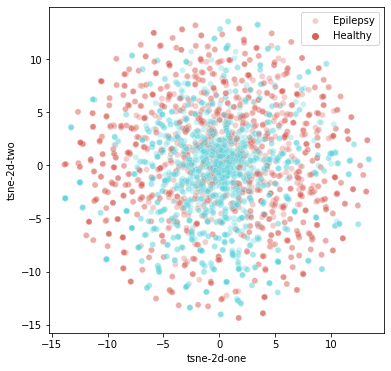

In [ ]:
#plotting
plt.figure(figsize=(6,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Labels",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.3
)
plt.legend(labels=['Epilepsy', 'Healthy'])

In [ ]:
patient = np.repeat(np.array(range(720)),4)
df['Patient']= patient

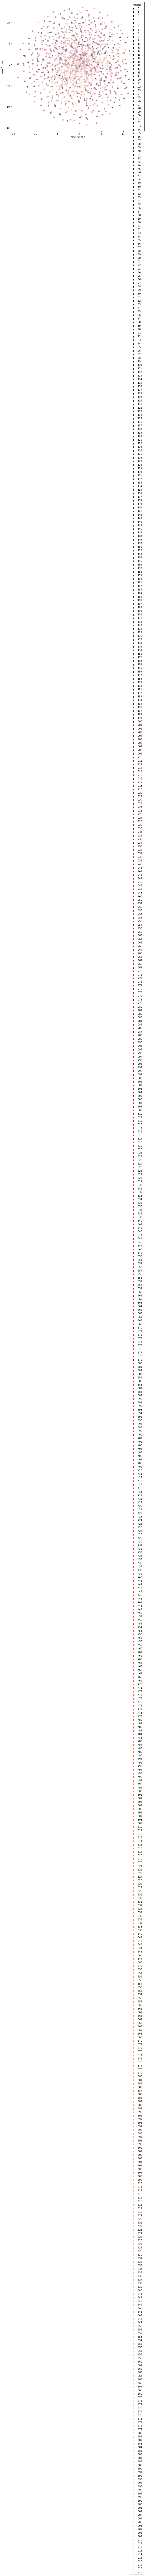

In [ ]:
#plotting with different color for every patient
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Patient",
    data=df,
    legend="full",
    alpha=0.3,
   palette=sns.color_palette("rocket", as_cmap=True)
)